In [3]:
from os.path import join
import numpy as np
import matplotlib.pyplot as plt

def load_data(load_dir, bid):
    SIZE = 512
    u = np.zeros((SIZE + 2, SIZE + 2))
    u[1:-1, 1:-1] = np.load(join(load_dir, f"{bid}_domain.npy"))
    interior_mask = np.load(join(load_dir, f"{bid}_interior.npy"))
    return u, interior_mask

def jacobi(u, interior_mask, max_iter, atol=1e-6):
    u = np.copy(u)
    for i in range(max_iter):
        u_new = 0.25 * (u[1:-1, :-2] + u[1:-1, 2:] + u[:-2, 1:-1] + u[2:, 1:-1])
        u_new_interior = u_new[interior_mask]
        delta = np.abs(u[1:-1, 1:-1][interior_mask] - u_new_interior).max()
        u[1:-1, 1:-1][interior_mask] = u_new_interior
        if delta < atol:
            break
    return u

def summary_stats(u, interior_mask):
    u_interior = u[1:-1, 1:-1][interior_mask]
    mean_temp = u_interior.mean()
    std_temp = u_interior.std()
    pct_above_18 = np.sum(u_interior > 18) / u_interior.size * 100
    pct_below_15 = np.sum(u_interior < 15) / u_interior.size * 100
    return {
        'mean_temp': mean_temp,
        'std_temp': std_temp,
        'pct_above_18': pct_above_18,
        'pct_below_15': pct_below_15,
    }


In [4]:
LOAD_DIR = '/dtu/projects/02613_2025/data/modified_swiss_dwellings/'

with open(join(LOAD_DIR, 'building_ids.txt'), 'r') as f:
    building_ids = f.read().splitlines()

# Only load N buildings
N = 3  # You can change this
building_ids = building_ids[:N]


In [5]:
all_u0 = np.empty((N, 514, 514))
all_interior_mask = np.empty((N, 512, 512), dtype='bool')

for i, bid in enumerate(building_ids):
    u0, interior_mask = load_data(LOAD_DIR, bid)
    all_u0[i] = u0
    all_interior_mask[i] = interior_mask


In [6]:
MAX_ITER = 20000
ABS_TOL = 1e-4

all_u = np.empty_like(all_u0)
for i, (u0, interior_mask) in enumerate(zip(all_u0, all_interior_mask)):
    u = jacobi(u0, interior_mask, MAX_ITER, ABS_TOL)
    all_u[i] = u


In [7]:
import pandas as pd

stat_keys = ['mean_temp', 'std_temp', 'pct_above_18', 'pct_below_15']
summary_list = []

for bid, u, interior_mask in zip(building_ids, all_u, all_interior_mask):
    stats = summary_stats(u, interior_mask)
    summary_list.append({'building_id': bid, **stats})

summary_df = pd.DataFrame(summary_list)
summary_df


,building_id,mean_temp,std_temp,pct_above_18,pct_below_15
0,10000,14.012339,6.367431,30.941015,55.542295
1,10009,11.000136,5.811144,16.671273,74.972359
2,10014,14.744170,7.037733,38.263675,52.808371


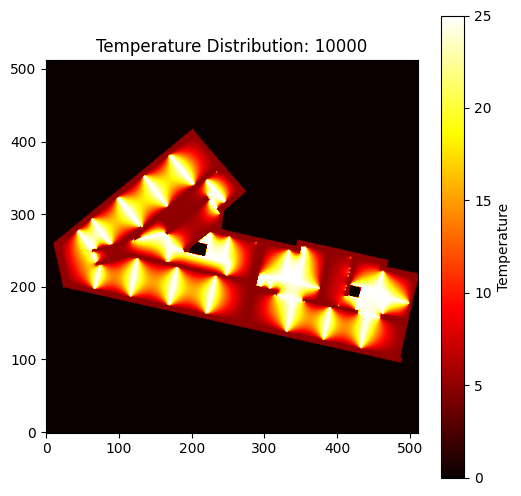

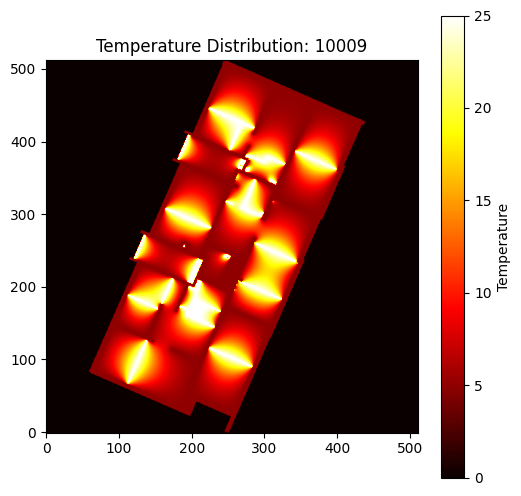

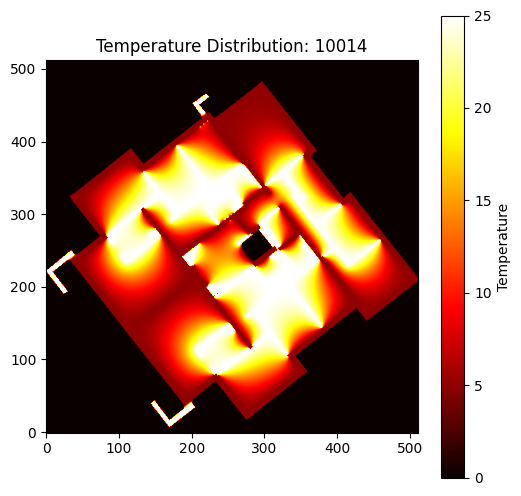

In [8]:
for i, bid in enumerate(building_ids):
    plt.figure(figsize=(6, 6))
    plt.imshow(all_u[i][1:-1, 1:-1], cmap='hot', origin='lower')
    plt.title(f"Temperature Distribution: {bid}")
    plt.colorbar(label='Temperature')
    plt.show()


Building ID: 10000
u0 shape (with ghost cells): (514, 514)
interior_mask shape: (512, 512)
Temperature range: 0.0 to 25.0


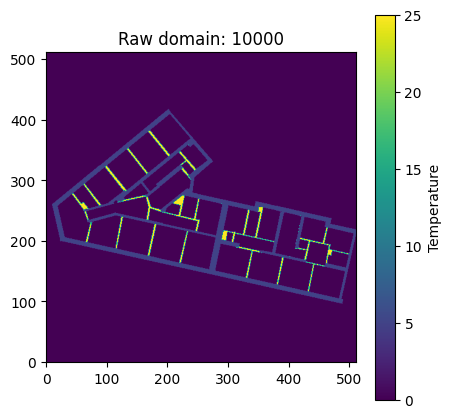

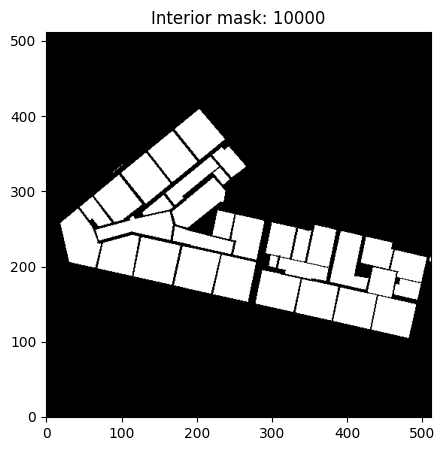

In [9]:
# --- new cell: inspect one building’s original data ---
bid = building_ids[0]
u0, interior_mask = load_data(LOAD_DIR, bid)

print(f"Building ID: {bid}")
print("u0 shape (with ghost cells):", u0.shape)
print("interior_mask shape:", interior_mask.shape)
print("Temperature range:", 
      u0[1:-1,1:-1].min(), "to", u0[1:-1,1:-1].max())

# plot raw domain
plt.figure(figsize=(5,5))
plt.imshow(u0[1:-1,1:-1], cmap='viridis', origin='lower')
plt.title(f"Raw domain: {bid}")
plt.colorbar(label='Temperature')
plt.show()

# plot interior mask
plt.figure(figsize=(5,5))
plt.imshow(interior_mask, cmap='gray', origin='lower')
plt.title(f"Interior mask: {bid}")
plt.show()

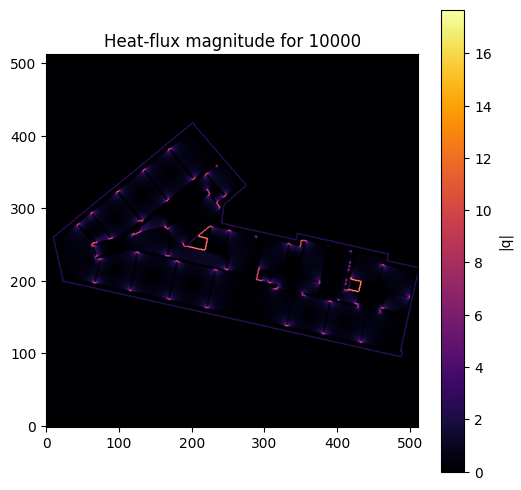

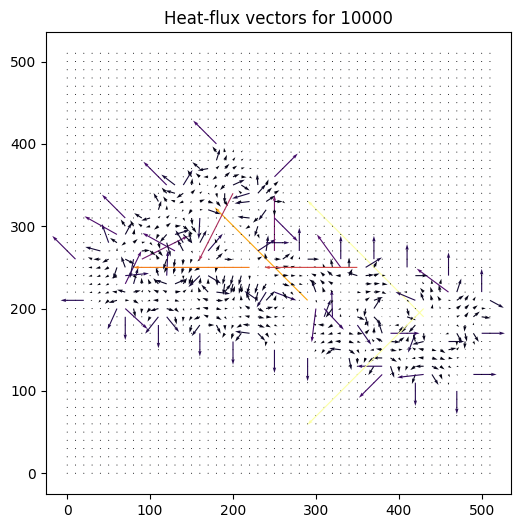

In [10]:
# --- how “heat” is calculated ---
# In our Jacobi solver we enforce ∇²T = 0 at steady state by
#    T_new[i,j] = ¼ (T[i+1,j] + T[i-1,j] + T[i,j+1] + T[i,j-1])
# which is the classic 5‑point Laplace stencil.
#
# We can also compute the heat‐flux vector q = -k ∇T (here k=1)
# and plot its magnitude and direction.

import numpy as np

# pick the first building
bid = building_ids[0]
u = all_u[0]
T = u[1:-1,1:-1]       # interior temperature field

# 1) compute gradients dT/dy, dT/dx
dTy, dTx = np.gradient(T)   # spacing=1
# 2) heat flux components
qx = -dTx
qy = -dTy

# plot flux magnitude
plt.figure(figsize=(6,6))
flux_mag = np.hypot(qx, qy)
plt.imshow(flux_mag, cmap='inferno', origin='lower')
plt.colorbar(label='|q|')
plt.title(f"Heat‐flux magnitude for {bid}")
plt.show()

# plot flux vectors (quiver)
plt.figure(figsize=(6,6))
step = 10
Y, X = np.mgrid[0:T.shape[0], 0:T.shape[1]]
plt.quiver(
    X[::step,::step], Y[::step,::step],
    qx[::step,::step], qy[::step,::step],
    flux_mag[::step,::step], cmap='inferno', scale=50
)
plt.title(f"Heat‐flux vectors for {bid}")
plt.show()